In [1]:
#hide
from pybrms import pybrms
import matplotlib.pyplot as plt
%matplotlib agg

# pybrms 

> a pythonic interface for R's brms

brms is a fantastic R package that allows users to fit many kinds of Bayesian regression models - linear models, GLMs, survival analysis, etc - all in a multilevel context. Models are concisely specified using R's formula syntax, and the corresponding Stan program and data are automatically generated.

pybrms aims to bring the ease-of-use of brms to python users; more sampling, less index-gymnastics and shape errors.

## Install

Install via pip:

`pip install pybrms`

This installs the python package along with its pythonic dependencies; when you first call `pybrms`, it'll install `brms` and its dependencies. Don't worry if you don't have R or brms installed - they will be installed in your current virtual environment.

## Example 

Let's use pybrms to fit a poisson regression model, including an interaction term and by-patient varying intercept. `pybrms` can import all datasets that are included in `brms`:

In [2]:
epilepsy = pybrms.get_brms_data("epilepsy")

Fitting the model is as simple as it is in `brms`:

In [3]:
model = pybrms.fit(
    formula = "count ~ zAge + zBase * Trt + (1 | patient)",
    stan_file = "epilepsy.stan",
    data = epilepsy, 
    family = "poisson"
)

INFO:cmdstanpy:compiling stan file C:\Users\username\github\pybrms\epilepsy.stan to exe file C:\Users\username\github\pybrms\epilepsy.exe
INFO:cmdstanpy:compiled model executable: C:\Users\username\github\pybrms\epilepsy.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/username/github/pybrms/epilepsy.hpp C:/Users/username/github/pybrms/epilepsy.stan
Warning in 'C:/Users/username/github/pybrms/epilepsy.stan', line 6, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/username/github/pybrms/epilepsy.stan', line 12, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the a

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


The user can also specify a list of priors, a `family` argument (is it a gaussian regression, binomial, poisson, etc), and optional `pystan` arguments like the number of chains, samples, etc. 

When sampling is completed, `fit` returns a `cmdstanpy` `StanModel` object. The generated stan code is also available in path provided for `fit`.

In [4]:
with open("epilepsy.stan") as f:
    print(f.read())

// generated with brms 2.16.3
functions {
}
data {
  int<lower=1> N;  // total number of observations
  int Y[N];  // response variable
  int<lower=1> K;  // number of population-level effects
  matrix[N, K] X;  // population-level design matrix
  // data for group-level effects of ID 1
  int<lower=1> N_1;  // number of grouping levels
  int<lower=1> M_1;  // number of coefficients per level
  int<lower=1> J_1[N];  // grouping indicator per observation
  // group-level predictor values
  vector[N] Z_1_1;
  int prior_only;  // should the likelihood be ignored?
}
transformed data {
  int Kc = K - 1;
  matrix[N, Kc] Xc;  // centered version of X without an intercept
  vector[Kc] means_X;  // column means of X before centering
  for (i in 2:K) {
    means_X[i - 1] = mean(X[, i]);
    Xc[, i - 1] = X[, i] - means_X[i - 1];
  }
}
parameters {
  vector[Kc] b;  // population-level effects
  real Intercept;  // temporary intercept for centered predictors
  vector<lower=0>[M_1] sd_1;  // group-l

## How it works

Behind the scene, `pybrms` calls `brms` via `rpy2`, handling the python-to-R-objects transitions in both directions and making sure that Stan gets the dtypes it expects by parsing the model's data block. 

More specifically, `pybrms` calls two `brms` functions: `make_stancode` and `make_standata`, which are used to generate the appropriate model code, design matrices, etc. These are then "pulled back" to python and fed into `cmdstanpy`.

## Adding priors

By defaults, `brms` uses non- or weakly-informative priors on model parameters. You can specify more informative priors using the following syntax:

In [5]:
model = pybrms.fit("count ~ zAge + zBase * Trt + (1|patient) + (1|obs)",
                                           stan_file = "epilepsy.stan",
                                           data = epilepsy, family = "poisson",
                                           priors = [("student_t(5,0,10)", "b"),
                                                     ("cauchy(0,2)", "sd")]
                                          )

INFO:cmdstanpy:compiling stan file C:\Users\username\github\pybrms\epilepsy.stan to exe file C:\Users\username\github\pybrms\epilepsy.exe
INFO:cmdstanpy:compiled model executable: C:\Users\username\github\pybrms\epilepsy.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/username/github/pybrms/epilepsy.hpp C:/Users/username/github/pybrms/epilepsy.stan
Warning in 'C:/Users/username/github/pybrms/epilepsy.stan', line 6, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/username/github/pybrms/epilepsy.stan', line 12, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the a

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Priors are passed as a list of tuples that conform to `brms` `set_prior` order of arguments - the first element is a Stan distribution, second is the class (b, Intercept, sd), third is coef, etc.

## Error handling

Error handling happens at the `rpy2` level, which catches the (R) error and displays it as a python `RRuntimeError` exception:

In [6]:
import traceback

try:
    model = pybrms.fit("count_typo ~ zAge + zBase * Trt + (1|patient) + (1|obs)",
                                               stan_file = "epilepsy.stan",
                                               data = epilepsy, family = "poisson",
                                               priors = [("student_t(5,0,10)", "b"),
                                                         ("cauchy(0,2)", "sd")]
                                              )
except Exception as exc:
        traceback.print_exc()


R[write to console]: Error: The following variables can neither be found in 'data' nor in 'data2':
'count_typo'

Traceback (most recent call last):
  File "C:\Users\username\AppData\Local\Temp\ipykernel_21176\1281510237.py", line 4, in <module>
    model = pybrms.fit("count_typo ~ zAge + zBase * Trt + (1|patient) + (1|obs)",
  File "C:\Users\username\github\pybrms\pybrms\pybrms.py", line 126, in fit
    model_code = get_stan_code(
  File "C:\Users\username\github\pybrms\pybrms\pybrms.py", line 55, in get_stan_code
    return brms.make_stancode(
  File "C:\Users\username\miniconda3\envs\stan\lib\site-packages\rpy2\robjects\functions.py", line 198, in __call__
    return (super(SignatureTranslatedFunction, self)
  File "C:\Users\username\miniconda3\envs\stan\lib\site-packages\rpy2\robjects\functions.py", line 125, in __call__
    res = super(Function, self).__call__(*new_args, **new_kwargs)
  File "C:\Users\username\miniconda3\envs\stan\lib\site-packages\rpy2\rinterface_lib\conversion.py

This makes sure you can debug your data/formula/etc without actually leaving python.

## Visualization

Since `pybrms` returns a `cmdstanpy` object, we can easily visualize the results using `arviz`:

In [7]:
%matplotlib inline

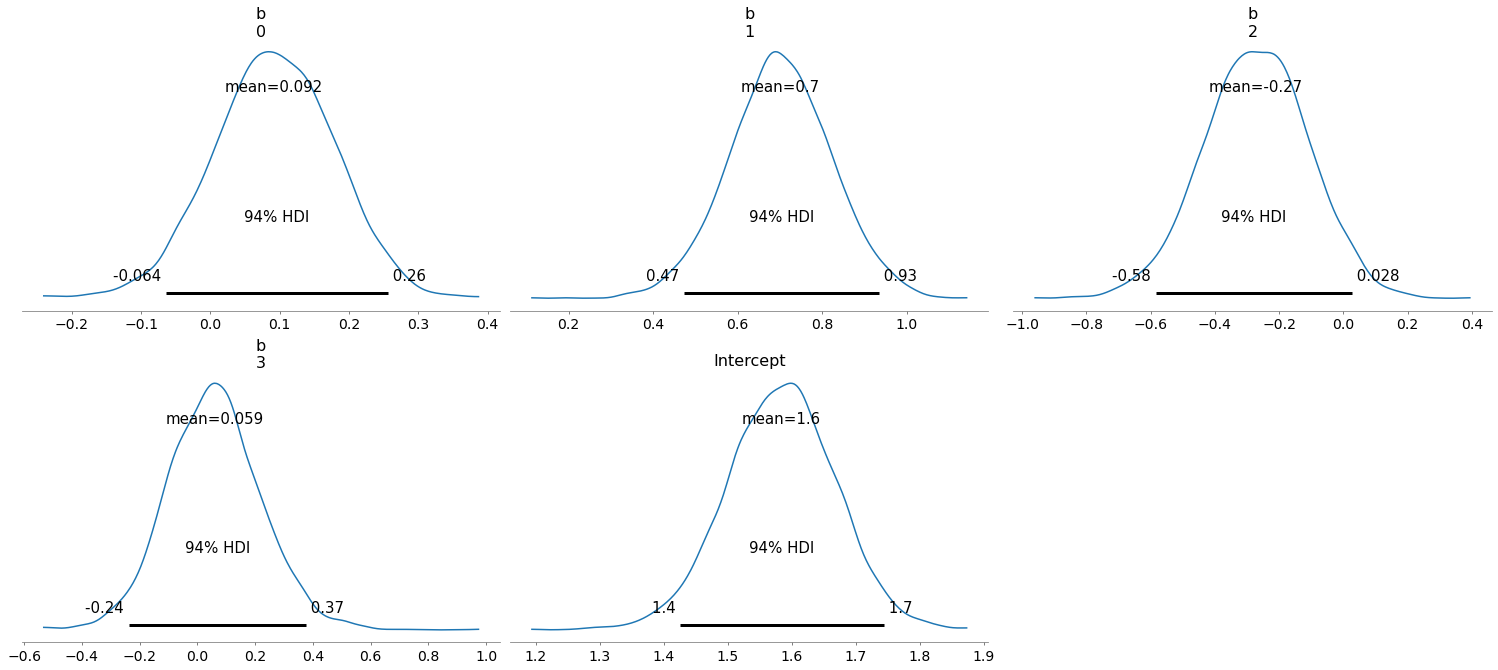

In [8]:
import arviz as az
inference_data = az.from_cmdstanpy(model)
az.plot_posterior(inference_data, var_names=['b', 'Intercept']);

For a more detailed walkthrough, see the accompanying [blog post](link).